## *Credit Card Fraud Prediciton and Business Decision Analysis*  

This project will consts mainly of three phases which are:

* Cleaning, EDA, and preprocessing.
* ML model selection, evaluation, and optimisation.
* Analytical insights documentation and reporting.  


Phase 1 and 2 will be present in this ipynb file. Phase 3, however, will be shown in a README file and/or a full documented PDF file report.

To get the most out of this project, I will consider the situation in a business context where, for example, I'm tasked with facilitating an analysis on the transactions of a transaction-related financial firm. The goal of this analysis is to:  
1) Explore solutions to detecting a fraud credit card transaction with an optimized Machine Learning model.
2) Find correlations between specific features or domains with a transaction being fraud.
3) Report and present best practices to decision-making bodies in the company to enhance the services.

Access the dataset through  this API code, or through the dataset provided

In [2]:
# import kagglehub
# path = kagglehub.dataset_download("dhanushnarayananr/credit-card-fraud")
# print(f"The path to the dataset on your machine is: {path}")

Phase 1:

To start the process I will divide this phase (sprint) into smaller tasks.

1) Summary statistics and overall understanding of the dataset with an overview inspection.
2) Cleaning, preparing and preprocessing data for analysis.  
3) Exploratory data analysis and presenting meaningful visualizations.
4) Splitting the data into testing and training (handling the imbalance)


In [3]:
########################################################################

This next section I will start inspecting the dataset showing statistical summaries and overall characteristics.

In [4]:
# importing the initial necessary libraries 
# (other needed packages will be imported throughout the file)
import pandas as pd
import numpy as np

df = pd.read_csv("card_transdata.csv")
df.head(2)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0


In [5]:
# Assuring no missing values (expected 1m observation)
print(len(df.dropna()))

1000000


In [6]:
print(f"Number of Observations is: {len(df)}")
print(f"Number of Attributes is: {len(df.columns)}")
for i, c in enumerate(df.columns):
    print(f"Feature {i+1} is: {c}")

Number of Observations is: 1000000
Number of Attributes is: 8
Feature 1 is: distance_from_home
Feature 2 is: distance_from_last_transaction
Feature 3 is: ratio_to_median_purchase_price
Feature 4 is: repeat_retailer
Feature 5 is: used_chip
Feature 6 is: used_pin_number
Feature 7 is: online_order
Feature 8 is: fraud


For the purpose of understanding the ML workflow, I did not put emphasis on the meaning of specific attributes, however they would be important in a more concise business context such that interpretability becomes easier. So distance measures, and ratio to median purchase are not clarified explicitly.

In [7]:
# Changing the names of featuers for convineince
# however this is not recommened to be done in a team-based scenario
df = df.rename(columns={'distance_from_home': 'home', 
                        'distance_from_last_transaction': 'trans', 
                        'ratio_to_median_purchase_price': "ratio",
                        'repeat_retailer': "repeat",
                        'used_chip': 'chip',
                        'used_pin_number': 'pin',
                        'online_order': 'online'})

In [8]:
df.describe()

,home,trans,ratio,repeat,chip,pin,online,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# statistical overview summary using pandas
desc = df[["home", "trans", "ratio"]].describe()
desc.iloc[1:, :]


,home,trans,ratio
mean,26.628792,5.036519,1.824182
std,65.390784,25.843093,2.799589
min,0.004874,0.000118,0.004399
25%,3.878008,0.296671,0.475673
50%,9.967760,0.998650,0.997717
75%,25.743985,3.355748,2.096370
max,10632.723672,11851.104565,267.802942


As seen by these non-binary descriptions, generally the standard deviaiton which measures the variance of each attribute, and they are shown to be as expected as ratios are not supposed to have a higher variance than distance measures.

In [10]:
# mean, std of binary values
second_desc = df[["repeat","chip","pin","online","fraud"]].describe()
second_desc.iloc[[1, 2], :]

,repeat,chip,pin,online,fraud
mean,0.881536,0.350399,0.100608,0.650552,0.087403
std,0.323157,0.477095,0.300809,0.476796,0.282425


As for the binary features, I can from a glance guess that there is a type of correlation (negative or positive) between the online and chip attributes, but I will need to calculate those explicitly later.  

If there are correlations between some features, it is usually better to exclude those features from the model to remove redundancy and increase informativity.

In [11]:
# Caluculating correlations between different attributes.

corred = df.corr()

# alpha is the value of correlation for a variable
# i tested with 0.5 and got no results, indicating no significant correlation between any two variables
# this is good for our machine learning process and analysis.
alpha = 0.3
for row in corred.iterrows():
    for column in row[1:]:
        for index, item in enumerate(column):
            if item >= alpha and item != 1:
                print(row[0])
                print(column)
            else:
                pass

# this code shows that the only correlation we have is between
# the transacation being fraud and having a higher price ratio to median purchase
# since this is a positive correlation with around 0.46 ~ 0.5 we will look into how to
# optimise for this situation

ratio
home     -0.001374
trans     0.001013
ratio     1.000000
repeat    0.001374
chip      0.000587
pin       0.000942
online   -0.000330
fraud     0.462305
Name: ratio, dtype: float64
fraud
home      0.187571
trans     0.091917
ratio     0.462305
repeat   -0.001357
chip     -0.060975
pin      -0.100293
online    0.191973
fraud     1.000000
Name: fraud, dtype: float64


In [12]:
# now we got an understanding of what the dataset is and what are the main features
# let's now see the imbalances
real = len(df[df["fraud"] == 0]) / 1000
fraud = len(df[df["fraud"] == 1]) / 1000
rate = round((fraud / real) * 100, 2)


print(f"There are {real}k authorised transactions")
print(f"There are {fraud}k fradulent transactions")
print(f"the ratio of fraud to real transactions is: {rate}%")

There are 912.597k authorised transactions
There are 87.403k fradulent transactions
the ratio of fraud to real transactions is: 9.58%


This suggests that an imbalance occurs even though this wasn't expected.  
I was expecting an even lower ratio, however, i will have to handle this imbalance anyway.
Accuracy would be an inefficient measure here so i will apply other evaluation methods.

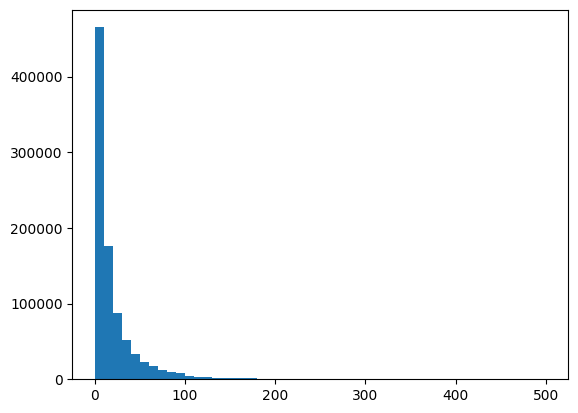

In [13]:
# Visualizing the dataset in histograms to get an idea of the non-binary data
import matplotlib.pyplot as plt

plt.hist(df[df["fraud"] == 0].loc[:, "home"], bins=50, histtype="stepfilled", range=(0, 500));

This graph shows a highly right skewed data suggesting less distance from home for every real transaction

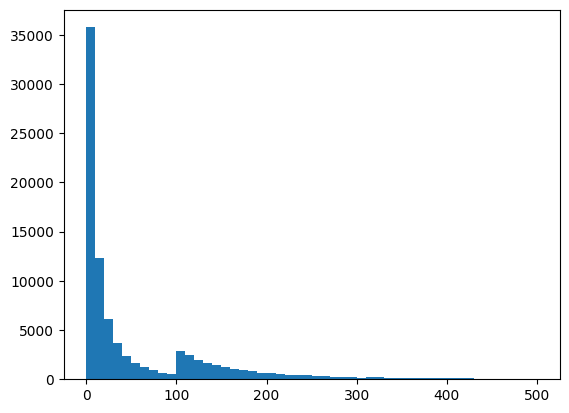

In [14]:
plt.hist(df[df["fraud"] == 1].loc[:, "home"], bins=50, histtype="stepfilled", range=(0, 500));

However, this grpah shows to have a higher rate of distance from home than the previous one.

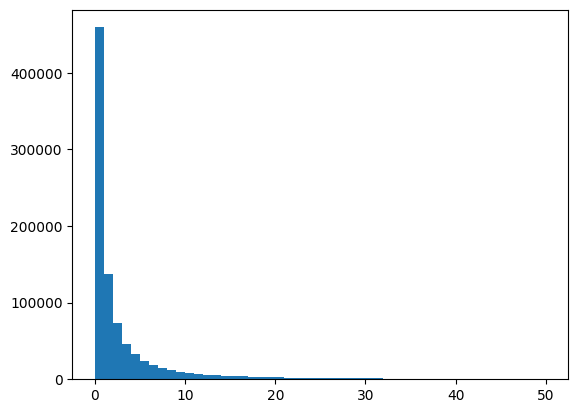

In [15]:
# here both fradulent and real transactions show the same histogram behaviour as (left skewed)
plt.hist(df[df["fraud"] == 0].loc[:, "trans"], bins=50, histtype="stepfilled", range=(0, 50));

In [104]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

non_binary = ["home", "trans", "ratio"]
binary = ["repeat", "chip", "pin", "online"]

scaler = StandardScaler()
scaler.fit(df[non_binary])

df[non_binary] = scaler.transform(df[non_binary])

X = df.drop(["fraud"], axis=1)

pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)

print(pca.explained_variance_ratio_)

[0.27480867 0.27417948 0.27361244 0.06236582 0.06228307 0.02795915
 0.02479137]


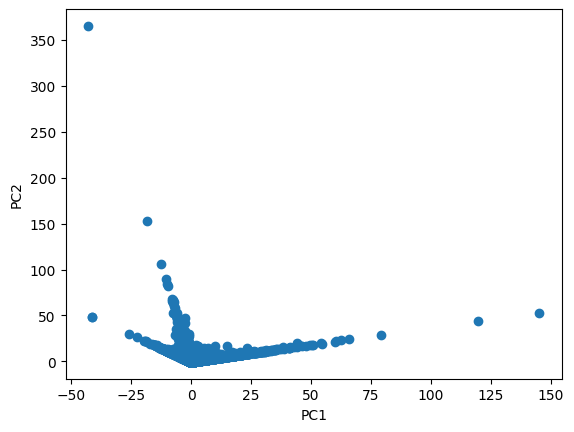

In [105]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

There are some clusters which indicate similar behaviours for most points. However, there are outliers alongside those pc's which probably showcase the fradulent transactions behaviour

In [106]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(len(X.columns))],
    index=X.columns
)

loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
home,0.895657,0.326873,0.297162,0.000373,0.000900,-0.051440,0.000465
trans,-0.092698,0.796833,-0.597045,-0.001237,-0.000299,0.000343,0.000296
ratio,-0.432546,0.507864,0.744968,-0.000388,0.000142,-0.000573,-0.000312
repeat,0.045918,0.016852,0.015940,-0.001405,-0.000601,0.998674,0.001406
chip,-0.000670,0.001049,-0.000621,0.985832,0.167716,0.001509,0.001460
pin,-0.000588,-0.000255,0.000250,-0.001386,-0.000548,-0.001383,0.999998
online,-0.000641,-0.000298,-0.000445,-0.167718,0.985834,0.000398,0.000308


This table shows how each feature contributes to each component. Indicating the the most variance in the dataset happend to be around the direction of the home variable for the first principal component

As expected there are some features that affect those components more than others. However, for example, the home_distance is negatively correlated with ratio to median purchase price in the first principal component suggesting most fradulent data happen to be the ones who are far from home "usually".The second component groups all three non-binary features in a positive correlation manner.

By this I can conclude that the binary features show an orthogonal behaviour to each other, indicating each one of them carries its own unique information that is not necessarily pushing or correlating with others, unlike non-binary features which can show a meaningful pattern of transactions, and correlation.

This is a good indicator that RandomForest are usually good to handle the unique informative features both with continuous features, and that all features are important with no redundancy.